# Variational Autoencoder (VAE) for Anime Images

Install Libraries

In [1]:
!pip install keras
!pip install matplotlib
!pip install numpy
!pip install tensorflow

Import Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation, LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.layers import Layer

Load and Preprocess Dataset

Download the dataset from here: https://drive.google.com/file/d/1lUmzcMUFJSF60DFMK5yKQClGqg9v8fcP/view?usp=sharing And extract it into your working directory

In [3]:
image_dir = "dataset/cropped/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['dataset/cropped/10009_2004.jpg', 'dataset/cropped/10032_2004.jpg']

In [4]:
# preprocess
image_size = 64

def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

In [5]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [6]:
len(training_dataset)

241

Visualize Images

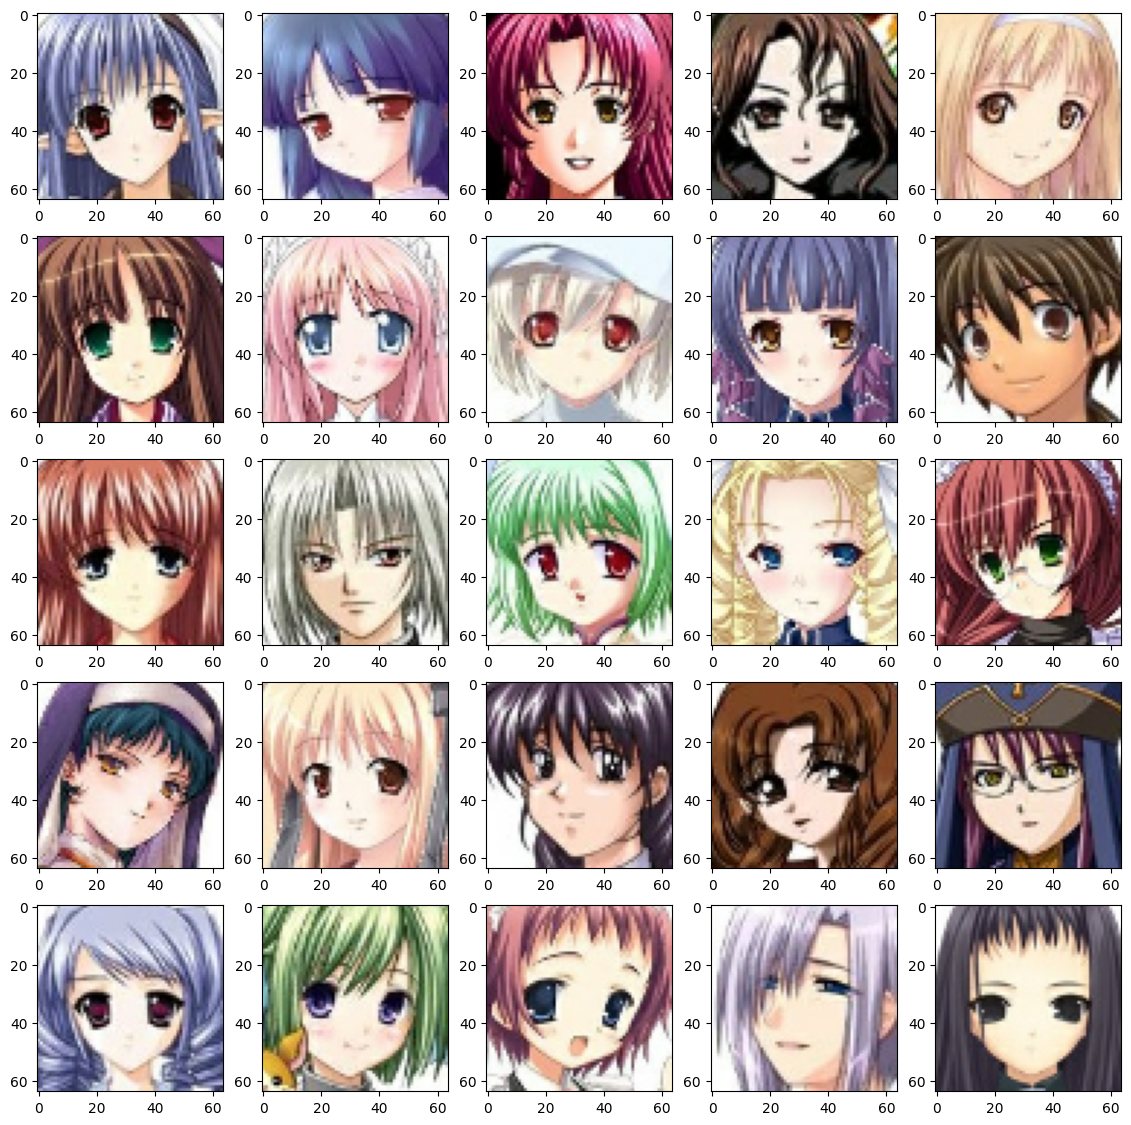

In [7]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [8]:
# build the model
latent_dim = 512

In [9]:
K.clear_session()

Build Encoder

In [10]:
encoder_input = Input(shape = (64,64,3))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

class Sampling(Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * log_var) * epsilon

# Use the Sampling layer in your model
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)
z = Sampling()([mu, log_var])  # This replaces the manual operation with epsilon

encoder = Model(encoder_input, outputs=[mu, log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    819,456 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  3,277,312 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  8,389,632 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 512)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,802,688 (52.65 MB)

 Trainable params: 13,798,656 (52.64 MB)

 Non-trainable params: 4,032 (15.75 KB)

Build Decoder

In [11]:
# Adjusted decoder model
decoder = Sequential([
    Input(shape=(latent_dim,)),  # Use Input layer to specify the input shape
    Dense(1024, activation=selu),
    BatchNormalization(),
    Dense(8192, activation=selu),
    Reshape((4, 4, 512)),
    Conv2DTranspose(256, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'),
    BatchNormalization(),
    Conv2DTranspose(128, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'),
    BatchNormalization(),
    Conv2DTranspose(64, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'),
    BatchNormalization(),
    Conv2DTranspose(32, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'),
    BatchNormalization(),
    Conv2DTranspose(3, (5, 5), activation="sigmoid", strides=1, padding='same'),
    BatchNormalization()
])

decoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         2,403 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,283,023 (50.67 MB)

 Trainable params: 13,280,009 (50.66 MB)

 Non-trainable params: 3,014 (11.77 KB)

Define Loss Functions

In [12]:
# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [13]:
class VAELossLayer(Layer):
    """Custom layer to compute VAE loss."""
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        y_true, y_pred, mu, log_var = inputs
        reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
        vae_loss = reconstruction_loss + (1 / (64 * 64)) * kl_loss
        self.add_loss(vae_loss)
        return y_pred  # Return reconstructed images for output

Build VAE Model

In [14]:
encoder_input = Input(shape=(64, 64, 3), name='encoder_input')
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)

# Add the custom VAE loss layer
vae_loss_layer = VAELossLayer()([encoder_input, reconstructed, mu, log_var])

model = Model(inputs=encoder_input, outputs=reconstructed, name="vae")

# Compile the model (you can still specify an optimizer, but not the loss here)
model.compile(optimizer='adam')
model.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 512), (None,   │    13,802,688 │
│                                 │ 512), (None, 512)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64, 64, 3)      │    13,283,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,085,711 (103.32 MB)

 Trainable params: 27,078,665 (103.30 MB)

 Non-trainable params: 7,046 (27.52 KB)

Define Function to Save Images

In [15]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

Train VAE

In [16]:
random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 20

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl)
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Epoch:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.09487779 - KL loss: 0
Epoch: 1 - Step: 1 - MSE loss: 0.095001064 - KL loss: 0
Epoch: 1 - Step: 2 - MSE loss: 0.097236656 - KL loss: 0
Epoch: 1 - Step: 3 - MSE loss: 0.093956046 - KL loss: 0
Epoch: 1 - Step: 4 - MSE loss: 0.0957124 - KL loss: 0
Epoch: 1 - Step: 5 - MSE loss: 0.09477929 - KL loss: 0
Epoch: 1 - Step: 6 - MSE loss: 0.096182585 - KL loss: 0
Epoch: 1 - Step: 7 - MSE loss: 0.09323552 - KL loss: 0
Epoch: 1 - Step: 8 - MSE loss: 0.09535953 - KL loss: 0
Epoch: 1 - Step: 9 - MSE loss: 0.09424156 - KL loss: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.092696 - KL loss: 0
Epoch: 1 - Step: 11 - MSE loss: 0.08974477 - KL loss: 0
Epoch: 1 - Step: 12 - MSE loss: 0.08959385 - KL loss: 0
Epoch: 1 - Step: 13 - MSE loss: 0.08913707 - KL loss: 0
Epoch: 1 - Step: 14 - MSE loss: 0.08645914 - KL loss: 0
Epoch: 1 - Step: 15 - MSE loss: 0.0775882 - 

Visualize Output

In [18]:
!pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.6 MB 656.4 kB/s eta 0:00:59
   ---------------------------------------- 0.1/38.6 MB 804.6 kB/s eta 0:00:48
   ---------------------------------------- 0.2/38.6 MB 876.1 kB/s eta 0:00:44
   ---------------------------------------- 0.2/38.6 MB 986.4 kB/s eta 0:00:39
   ---------------------------------------- 0.2/38.6 MB 942.1 kB/s eta 0:00:41
   ---------------------------------------- 0.3/38.6 MB 934.1 kB/s eta 0:00:42
   ---------------------------------------- 0.3/38.6 MB 791.9 kB/s eta 0:00:49
   ---------------------------------------- 0.3/38.6 MB 778.3 kB/s eta 0:00:50
   ---------------------------------------- 0.4/38.6 MB 881.6 kB/s eta 0:00:44
    --------------------------------------- 0.6/38.6 MB 1.1 MB/s eta 0:00:34
  

In [19]:
import cv2

In [20]:
output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break